In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import XYZfromAET, AETfromXYZ

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

import multiprocessing
# if __name__=='__main__':
#     multiprocessing.set_start_method("fork")
    # multiprocessing.set_start_method("spawn")

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has BBHx waveform


## Test interpolation on complex function

In [2]:
x = np.array([0, 1, 2, 3])
y = np.array([1+2j, 3+4j, 5+6j, 7+8j])  # 复数数据

akima = interp.Akima1DInterpolator(x, y)
print(akima(1.5))  # 输出复数插值结果，如 (4.0+5.0j)

(4+5j)


/tmp/ipykernel_153467/528525092.py:4: DeprecationWarning: `Akima1DInterpolator` only works with real values for `y`. Passing an array with a complex dtype for `y` is deprecated and will raise an error in SciPy 1.15.0. If you are trying to use the real components of the passed array, use `np.real` on the array before passing to `Akima1DInterpolator`.
  akima = interp.Akima1DInterpolator(x, y)
/home/ps/miniconda3/envs/triangle/lib/python3.9/site-packages/scipy/interpolate/_cubic.py:526: ComplexWarning: Casting complex values to real discards the imaginary part
  m[2:-2] = np.diff(y, axis=0) / dx


In [3]:
x = xp.array([0, 1, 2, 3])
y = xp.array([1+2j, 3+4j, 5+6j, 7+8j])  # 复数数据

akima = xinterp.Akima1DInterpolator(x, y)
print(akima(1.5))  # 输出复数插值结果，如 (4.0+5.0j)

/home/ps/miniconda3/envs/taiji_data/lib/python3.9/site-packages/cupyx/scipy/interpolate/_cubic.py:372: ComplexWarning: Casting complex values to real discards the imaginary part
  m[2:-2] = cupy.diff(y, axis=0) / dx


(4+5j)


## New response 

In [4]:
class BBHxFDTDIResponseGenerator_interp():
    """  
        The rule of Fourier transform is the same as S. Marsat, which is an ``unusual'' convention,
        aiming to ensure h_lm(f) neq 0 when m > 0 and f > 0.
        Accordingly, h_lm(f) = A_lm(f) * exp[-i Psi_lm(f)].
        The waveform class outputs Phi_lm(f) = -Psi_lm(f), thus h_lm(f) = A_lm(f) exp[i Phi_lm(f)]
        While, the complex conjugate of results will be taken at last to convert to the usual FT convension.
        
        Parameters should be given in the form of dictionary, with the keys denoting the names of parameters, 
        including:
        "chirp_mass" [MSUN], "mass_ratio" [1], "spin_1z" [1], "spin_2z" [1], 
        "coalescence_time" [DAY] (at the center of detector constellation), "coalescence_phase" [rad],
        "luminosity_distance" [MPC], "inclination" [rad], 
        "longitude" [rad], "latitude" [rad], "psi" [rad]
        
        modes = [(2, 2)] for PhenomD and [(2, 2), (2, 1), (3, 2), (3, 3), (4, 3), (4, 4)] for PhenomHM
    """
    ep_0 = np.array(
        [[1, 0, 0], 
         [0, -1, 0], 
         [0, 0, 0]]
        )
    ec_0 = np.array(
        [[0, 1, 0], 
         [1, 0, 0], 
         [0, 0, 0]]
        )
    def __init__(self, orbit_class, waveform_generator, use_gpu):
        self.orbit = orbit_class
        self.PositionFunctions = self.orbit.Positionfunctions()
        self.ArmVectorFunctions = self.orbit.ArmVectorfunctions()
        self.LTTFunctions = self.orbit.LTTfunctions()     
            
        self.waveform = waveform_generator
        
        self.use_gpu = use_gpu
        if use_gpu: 
            self.xp = xp 
            self.xinterp = xinterp
        else: 
            self.xp = np 
            self.xinterp = interp
            
        self.POS_time_int = orbit_class.POS_time_int
        self.POS_data_int = orbit_class.POS_data_int
        self.ARM_time_int = orbit_class.ARM_time_int
        self.ARM_data_int = orbit_class.ARM_data_int
        self.LTT_time_int = orbit_class.LTT_time_int
        self.LTT_data_int = orbit_class.LTT_data_int   
        for data_dict in [self.POS_time_int, self.POS_data_int, self.ARM_time_int, self.ARM_data_int, self.LTT_time_int, self.LTT_data_int]:
            for k, v in data_dict.items():
                data_dict[k] = self.xp.array(v)

        if use_gpu: 
            self.ep_0 = self.xp.array(self.ep_0)
            self.ec_0 = self.xp.array(self.ec_0)
        
    def SpinWeightedSphericalHarmonic(self, theta, phi, l, m, s=-2):
        # Taken from arXiv:0709.0093v3 eq. (II.7), (II.8) and LALSimulation for the s=-2 case and up to l=4
        """  
            The results are in consistency with LDC Radler manual.
            theta, phi: spherical coordinates of the source frame (i.e. iota0 and phi0 in the LDC manual). 
            This function allows vectorized inputs and outputs.
        """
        
        if s != -2:
            raise ValueError('The only spin-weight implemented for the moment is s = -2.')
            
        if (2 == l):
            if (-2 == m):
                res = self.xp.sqrt( 5.0 / ( 64.0 * PI ) ) * ( 1.0 - self.xp.cos( theta ))*( 1.0 - self.xp.cos( theta ))
            elif (-1 == m):
                res = self.xp.sqrt( 5.0 / ( 16.0 * PI ) ) * self.xp.sin( theta )*( 1.0 - self.xp.cos( theta ))
            elif (0 == m):
                res = self.xp.sqrt( 15.0 / ( 32.0 * PI ) ) * self.xp.sin( theta )*self.xp.sin( theta )
            elif (1 == m):
                res = self.xp.sqrt( 5.0 / ( 16.0 * PI ) ) * self.xp.sin( theta )*( 1.0 + self.xp.cos( theta ))
            elif (2 == m):
                res = self.xp.sqrt( 5.0 / ( 64.0 * PI ) ) * ( 1.0 + self.xp.cos( theta ))*( 1.0 + self.xp.cos( theta ))
            else:
                raise ValueError('Invalid m for l = 2.')
                
        elif (3 == l):
            if (-3 == m):
                res = self.xp.sqrt(21.0/(TWOPI))*self.xp.cos(theta*0.5)*((self.xp.sin(theta*0.5))**(5.))
            elif (-2 == m):
                res = self.xp.sqrt(7.0/(4.0*PI))*(2.0 + 3.0*self.xp.cos(theta))*((self.xp.sin(theta*0.5))**(4.0))
            elif (-1 == m):
                res = self.xp.sqrt(35.0/(TWOPI))*(self.xp.sin(theta) + 4.0*self.xp.sin(2.0*theta) - 3.0*self.xp.sin(3.0*theta))/32.0
            elif (0 == m):
                res = (self.xp.sqrt(105.0/(TWOPI))*self.xp.cos(theta)*(self.xp.sin(theta)*self.xp.sin(theta)))*0.25
            elif (1 == m):
                res = -self.xp.sqrt(35.0/(TWOPI))*(self.xp.sin(theta) - 4.0*self.xp.sin(2.0*theta) - 3.0*self.xp.sin(3.0*theta))/32.0
            elif (2 == m):
                res = self.xp.sqrt(7.0/PI)*((self.xp.cos(theta*0.5))**(4.0))*(-2.0 + 3.0*self.xp.cos(theta))*0.5
            elif (3 == m):
                res = -self.xp.sqrt(21.0/(TWOPI))*((self.xp.cos(theta/2.0))**(5.0))*self.xp.sin(theta*0.5)
            else:
                raise ValueError('Invalid m for l = 3.')
                
        elif (4 == l):
            if (-4 == m):
                res = 3.0*self.xp.sqrt(7.0/PI)*(self.xp.cos(theta*0.5)*self.xp.cos(theta*0.5))*((self.xp.sin(theta*0.5))**6.0)
            elif (-3 == m):
                res = 3.0*self.xp.sqrt(7.0/(TWOPI))*self.xp.cos(theta*0.5)*(1.0 + 2.0*self.xp.cos(theta))*((self.xp.sin(theta*0.5))**5.0)
            elif (-2 == m):
                res = (3.0*(9.0 + 14.0*self.xp.cos(theta) + 7.0*self.xp.cos(2.0*theta))*((self.xp.sin(theta/2.0))**4.0))/(4.0*self.xp.sqrt(PI))
            elif (-1 == m):
                res = (3.0*(3.0*self.xp.sin(theta) + 2.0*self.xp.sin(2.0*theta) + 7.0*self.xp.sin(3.0*theta) - 7.0*self.xp.sin(4.0*theta)))/(32.0*self.xp.sqrt(TWOPI))
            elif (0 == m):
                res = (3.0*self.xp.sqrt(5.0/(TWOPI))*(5.0 + 7.0*self.xp.cos(2.0*theta))*(self.xp.sin(theta)*self.xp.sin(theta)))/16.
            elif (1 == m):
                res = (3.0*(3.0*self.xp.sin(theta) - 2.0*self.xp.sin(2.0*theta) + 7.0*self.xp.sin(3.0*theta) + 7.0*self.xp.sin(4.0*theta)))/(32.0*self.xp.sqrt(TWOPI))
            elif (2 == m):
                res = (3.0*((self.xp.cos(theta*0.5))**4.0)*(9.0 - 14.0*self.xp.cos(theta) + 7.0*self.xp.cos(2.0*theta)))/(4.0*self.xp.sqrt(PI))
            elif (3 == m):
                res = -3.0*self.xp.sqrt(7.0/(TWOPI))*((self.xp.cos(theta*0.5))**5.0)*(-1.0 + 2.0*self.xp.cos(theta))*self.xp.sin(theta*0.5)
            elif (4 == m):
                res = 3.0*self.xp.sqrt(7.0/PI)*((self.xp.cos(theta*0.5))**6.0)*(self.xp.sin(theta*0.5)*self.xp.sin(theta*0.5))
            else:
                raise ValueError('Invalid m for l = 4.')
                
        else:
            raise ValueError('Multipoles with l > 4 not implemented yet.')
        
        return res*self.xp.exp(1j*m*phi)
        
        
    def WaveVector(self, parameters):
        """ 
            returns:
            k: wave vector of GW
        """
        l, b = parameters['longitude'], parameters['latitude']
        # shape of k: (Nevents, 3)
        k = -self.xp.array([self.xp.cos(l) * self.xp.cos(b), self.xp.sin(l) * self.xp.cos(b), self.xp.sin(b)])
        return self.xp.transpose(k)
    
    def PolarBasis(self, parameters):
        """ 
            returns:
            ep, ec: polarization bases of GW in the source frame 
        """
        l, b, p = parameters['longitude'], parameters['latitude'], parameters['psi']
        Nevents = l.shape[0]
        
        # shape of O and OT: (Nevents, 3, 3)
        O = self.xp.zeros((3, 3, Nevents))
        O[0][0] = self.xp.sin(l) * self.xp.cos(p) - self.xp.cos(l) * self.xp.sin(b) * self.xp.sin(p)
        O[0][1] = -self.xp.sin(l) * self.xp.sin(p) - self.xp.cos(l) * self.xp.sin(b) * self.xp.cos(p)
        O[0][2] = -self.xp.cos(l) * self.xp.cos(b)
        O[1][0] = -self.xp.cos(l) * self.xp.cos(p) - self.xp.sin(l) * self.xp.sin(b) * self.xp.sin(p)
        O[1][1] = self.xp.cos(l) * self.xp.sin(p) - self.xp.sin(l) * self.xp.sin(b) * self.xp.cos(p)
        O[1][2] = -self.xp.sin(l) * self.xp.cos(b)
        O[2][0] = self.xp.cos(b) * self.xp.sin(p)
        O[2][1] = self.xp.cos(b) * self.xp.cos(p)
        O[2][2] = -self.xp.sin(b)
        O = self.xp.transpose(O, (2, 0, 1))
        OT = self.xp.transpose(O, (0, 2, 1))
        
        # shapes of e+ and ex: (Nevents, 3, 3)        
        ep = self.xp.matmul(self.xp.matmul(O, self.ep_0), OT)
        ec = self.xp.matmul(self.xp.matmul(O, self.ec_0), OT)
        return ep, ec
    
    def PolarBasis_lm(self, parameters, modes=[(2, 2), (3, 3), (4, 4), (2, 1), (3, 2), (4, 3)]):
        """ 
            Polarizations basis tensor Plm for each (l, m) mode stored in a dictionary with the keys being modes.
            The shape of each Plm item is (Nevents, 3, 3).
            Plm = P^+_lm + P^x_lm 
            P^A_lm = K^A_lm * e^A, where A \in {+, x} should be summed over
            K^+_lm = 1/2 * [Ylm + (-1)^l Yl-m^*]
            K^x_lm = i/2 * [Ylm - (-1)^l Yl-m^*]
            the expressions of K are consistent in LDC Radler manual and S. Marsat
        """
        iota0, phi0 = parameters['inclination'], parameters['coalescence_phase']
        
        ep, ec = self.PolarBasis(parameters=parameters)
        
        # Plm 
        Plm = {}
        for l, m in modes:
            # array of shape (Nevents)
            Ylm = self.SpinWeightedSphericalHarmonic(theta=iota0, phi=phi0, l=l, m=m)
            Yl_m_star = self.xp.conjugate(self.SpinWeightedSphericalHarmonic(theta=iota0, phi=phi0, l=l, m=-m)) * (-1.) ** l
            Kplm = 0.5 * (Ylm + Yl_m_star)
            Kclm = 0.5j * (Ylm - Yl_m_star)
            
            Plm[(l, m)] = \
                self.xp.expand_dims(self.xp.expand_dims(Kplm, axis=-1), axis=-1) * ep \
                + self.xp.expand_dims(self.xp.expand_dims(Kclm, axis=-1), axis=-1) * ec
        return Plm 
    

    def TransferFunction(self, t, f, k, Plm, TDIGeneration='2nd', tmin=None, tmax=None):
        """  
            t and f should have the same shape (Nevents, Nfreqs). 
            k is the wave vector of GW with shape (Nevents, 3)
            Plm is the polar basis of a specific (l, m) mode with shape (Nevents, 3, 3).
            
            arraies which should be calculated for each `ij' arm:
            dij : (Nevents, Nfreqs) in second unit 
            nij : (Nevents, Nfreqs, 3)
            knij : (Nevents, Nfreqs)
            pi : (Nevents, Nfreqs, 3) in second unit 
            pj : (Nevents, Nfreqs, 3)
            prefactorij : (Nevents, Nfreqs)
            sincfactorij : (Nevents, Nfreqs)
            expfactorij : (Nevents, Nfreqs)
            Fij : (Nevents, Nfreqs) = nij \bigocross nij : Plm
            Gij : (Nevents, Nfreqs) i.e. G^lm_slr in S. Marsat
            X/Y/Z plus/minus factor : (Nevents, Nfreqs)
            GTDI : (Nevnets, Nfreqs) i.e. transfer functions for TDI channels X, Y, Z
            these values all depend on lm implicitly due to the t-f relations, thus should be calculated per mode
            the data will first be calculated at the frequency grids and  stored in dictionaries.
            
            Transfer functions before tmin [DAY] are set to 0.
        """
        (Nevents, Nfreqs) = t.shape
        t_flatten = t.flatten()
        
        # positions 
        # p1 = self.PositionFunctions['1'](t)
        # p2 = self.PositionFunctions['2'](t)
        # p3 = self.PositionFunctions['3'](t)
        p1 = self.xp.array([
            self.xp.interp(x=t_flatten, xp=self.POS_time_int["1"], fp=self.POS_data_int["1"][:, 0]),
            self.xp.interp(x=t_flatten, xp=self.POS_time_int["1"], fp=self.POS_data_int["1"][:, 1]),
            self.xp.interp(x=t_flatten, xp=self.POS_time_int["1"], fp=self.POS_data_int["1"][:, 2]),
        ]).transpose().reshape((Nevents, Nfreqs, 3))
        p2 = self.xp.array([
            self.xp.interp(x=t_flatten, xp=self.POS_time_int["2"], fp=self.POS_data_int["2"][:, 0]),
            self.xp.interp(x=t_flatten, xp=self.POS_time_int["2"], fp=self.POS_data_int["2"][:, 1]),
            self.xp.interp(x=t_flatten, xp=self.POS_time_int["2"], fp=self.POS_data_int["2"][:, 2]),
        ]).transpose().reshape((Nevents, Nfreqs, 3))
        p3 = self.xp.array([
            self.xp.interp(x=t_flatten, xp=self.POS_time_int["3"], fp=self.POS_data_int["3"][:, 0]),
            self.xp.interp(x=t_flatten, xp=self.POS_time_int["3"], fp=self.POS_data_int["3"][:, 1]),
            self.xp.interp(x=t_flatten, xp=self.POS_time_int["3"], fp=self.POS_data_int["3"][:, 2]),
        ]).transpose().reshape((Nevents, Nfreqs, 3))
        
        # arm lengths 
        # d12 = self.LTTFunctions['12'](t)
        # d13 = self.LTTFunctions['13'](t)
        # d23 = self.LTTFunctions['23'](t)
        # d21 = self.LTTFunctions['21'](t)
        # d31 = self.LTTFunctions['31'](t)
        # d32 = self.LTTFunctions['32'](t)
        d12 = self.xp.interp(x=t_flatten, xp=self.LTT_time_int["12"], fp=self.LTT_data_int["12"]).reshape((Nevents, Nfreqs))
        d13 = self.xp.interp(x=t_flatten, xp=self.LTT_time_int["13"], fp=self.LTT_data_int["13"]).reshape((Nevents, Nfreqs))
        d23 = self.xp.interp(x=t_flatten, xp=self.LTT_time_int["23"], fp=self.LTT_data_int["23"]).reshape((Nevents, Nfreqs))
        d21 = self.xp.interp(x=t_flatten, xp=self.LTT_time_int["21"], fp=self.LTT_data_int["21"]).reshape((Nevents, Nfreqs))
        d31 = self.xp.interp(x=t_flatten, xp=self.LTT_time_int["31"], fp=self.LTT_data_int["31"]).reshape((Nevents, Nfreqs))
        d32 = self.xp.interp(x=t_flatten, xp=self.LTT_time_int["32"], fp=self.LTT_data_int["32"]).reshape((Nevents, Nfreqs))
        
        # arm directions 
        # n12 = self.ArmVectorFunctions['12'](t)
        # n13 = self.ArmVectorFunctions['13'](t)
        # n23 = self.ArmVectorFunctions['23'](t)
        # n21 = self.ArmVectorFunctions['21'](t)
        # n31 = self.ArmVectorFunctions['31'](t)
        # n32 = self.ArmVectorFunctions['32'](t)
        n12 = self.xp.array([
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["12"], fp=self.ARM_data_int["12"][:, 0]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["12"], fp=self.ARM_data_int["12"][:, 1]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["12"], fp=self.ARM_data_int["12"][:, 2]),
        ]).transpose().reshape((Nevents, Nfreqs, 3))
        n13 = self.xp.array([
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["13"], fp=self.ARM_data_int["13"][:, 0]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["13"], fp=self.ARM_data_int["13"][:, 1]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["13"], fp=self.ARM_data_int["13"][:, 2]),
        ]).transpose().reshape((Nevents, Nfreqs, 3))
        n23 = self.xp.array([
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["23"], fp=self.ARM_data_int["23"][:, 0]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["23"], fp=self.ARM_data_int["23"][:, 1]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["23"], fp=self.ARM_data_int["23"][:, 2]),
        ]).transpose().reshape((Nevents, Nfreqs, 3))
        n21 = self.xp.array([
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["21"], fp=self.ARM_data_int["21"][:, 0]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["21"], fp=self.ARM_data_int["21"][:, 1]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["21"], fp=self.ARM_data_int["21"][:, 2]),
        ]).transpose().reshape((Nevents, Nfreqs, 3))
        n31 = self.xp.array([
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["31"], fp=self.ARM_data_int["31"][:, 0]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["31"], fp=self.ARM_data_int["31"][:, 1]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["31"], fp=self.ARM_data_int["31"][:, 2]),
        ]).transpose().reshape((Nevents, Nfreqs, 3))
        n32 = self.xp.array([
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["32"], fp=self.ARM_data_int["32"][:, 0]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["32"], fp=self.ARM_data_int["32"][:, 1]),
            self.xp.interp(x=t_flatten, xp=self.ARM_time_int["32"], fp=self.ARM_data_int["32"][:, 2]),
        ]).transpose().reshape((Nevents, Nfreqs, 3))
        
        # k \dot n 
        ke = self.xp.expand_dims(k, axis=1)
        kn12 =  self.xp.sum(ke * n12, axis=2)
        kn13 =  self.xp.sum(ke * n13, axis=2)
        kn23 =  self.xp.sum(ke * n23, axis=2)
        kn21 =  self.xp.sum(ke * n21, axis=2)
        kn31 =  self.xp.sum(ke * n31, axis=2)
        kn32 =  self.xp.sum(ke * n32, axis=2)
        
        # k \dot (p_receive + p_send)
        kp1p2 = self.xp.sum(ke * (p1 + p2), axis=2)
        kp2p3 = self.xp.sum(ke * (p2 + p3), axis=2)
        kp3p1 = self.xp.sum(ke * (p3 + p1), axis=2)
        
        # prefactor = i*PI*f*d
        prefactor12 = 1.j * PI * f * d12
        prefactor13 = 1.j * PI * f * d13
        prefactor23 = 1.j * PI * f * d23
        prefactor21 = 1.j * PI * f * d21
        prefactor31 = 1.j * PI * f * d31
        prefactor32 = 1.j * PI * f * d32
        
        # sincfactor = sinc(PI*f*d*(1-kn)) = self.xp.sinc(f*d*(1-kn))
        sincfactor12 = self.xp.sinc(f * d12 * (1. - kn12))
        sincfactor13 = self.xp.sinc(f * d13 * (1. - kn13))
        sincfactor23 = self.xp.sinc(f * d23 * (1. - kn23))
        sincfactor21 = self.xp.sinc(f * d21 * (1. - kn21))
        sincfactor31 = self.xp.sinc(f * d31 * (1. - kn31))
        sincfactor32 = self.xp.sinc(f * d32 * (1. - kn32))
        
        # expfactor = exp(i*PI*f*(d+k(p_receive+p_send)))
        expfactor12 = self.xp.exp(1.j * PI * f * (d12 + kp1p2))
        expfactor13 = self.xp.exp(1.j * PI * f * (d13 + kp3p1))
        expfactor23 = self.xp.exp(1.j * PI * f * (d23 + kp2p3))
        expfactor21 = self.xp.exp(1.j * PI * f * (d21 + kp1p2))
        expfactor31 = self.xp.exp(1.j * PI * f * (d31 + kp3p1))
        expfactor32 = self.xp.exp(1.j * PI * f * (d32 + kp2p3))
        
        # antenna pattern functions Fij
        # matmul(n12, Plm) is of shape (Nevents, Nfreqs, 3)
        F12 = self.xp.sum(self.xp.matmul(n12, Plm) * n12, axis=2)
        F13 = self.xp.sum(self.xp.matmul(n13, Plm) * n13, axis=2)
        F23 = self.xp.sum(self.xp.matmul(n23, Plm) * n23, axis=2)
        F21 = self.xp.sum(self.xp.matmul(n21, Plm) * n21, axis=2)
        F31 = self.xp.sum(self.xp.matmul(n31, Plm) * n31, axis=2)
        F32 = self.xp.sum(self.xp.matmul(n32, Plm) * n32, axis=2)
        
        # combine into single-arm transferfunction  Gij
        Gij = {}
        Gij['12'] = prefactor12 * sincfactor12 * expfactor12 * F12
        Gij['13'] = prefactor13 * sincfactor13 * expfactor13 * F13
        Gij['23'] = prefactor23 * sincfactor23 * expfactor23 * F23
        Gij['21'] = prefactor21 * sincfactor21 * expfactor21 * F21
        Gij['31'] = prefactor31 * sincfactor31 * expfactor31 * F31
        Gij['32'] = prefactor32 * sincfactor32 * expfactor32 * F32
        
        # delay factors 
        D12 = self.xp.exp(1.j * TWOPI * f * d12) 
        D13 = self.xp.exp(1.j * TWOPI * f * d13) 
        D23 = self.xp.exp(1.j * TWOPI * f * d23) 
        D21 = self.xp.exp(1.j * TWOPI * f * d21) 
        D31 = self.xp.exp(1.j * TWOPI * f * d31) 
        D32 = self.xp.exp(1.j * TWOPI * f * d32) 
        
        # combine into TDI transferfunction GTDI
        if TDIGeneration == '1st':
            X1plusfactor = (1. - D12 * D21) 
            X1minusfactor = (1. - D13 * D31) 
            Y1plusfactor = (1. - D23 * D32) 
            Y1minusfactor = (1. - D21 * D12) 
            Z1plusfactor = (1. - D31 * D13) 
            Z1minusfactor = (1. - D32 * D23) 
            GTDI = {} 
            GTDI['X'] = X1plusfactor * (Gij['13'] + Gij['31'] * D13) - X1minusfactor * (Gij['12'] + Gij['21'] * D12)
            GTDI['Y'] = Y1plusfactor * (Gij['21'] + Gij['12'] * D21) - Y1minusfactor * (Gij['23'] + Gij['32'] * D23)
            GTDI['Z'] = Z1plusfactor * (Gij['32'] + Gij['23'] * D32) - Z1minusfactor * (Gij['31'] + Gij['13'] * D31)
            
        elif TDIGeneration == '2nd':
            D121 = D12 * D21
            D131 = D13 * D31 
            D12131_1 = 1. - D121 * D131 # 1 - D12131
            X2plusfactor = (1. - D121) * D12131_1
            X2minusfactor = (1. - D131) * D12131_1
            D232 = D23 * D32 
            D212 = D21 * D12 
            D23212_1 = 1. - D232 * D212 
            Y2plusfactor = (1. - D232) * D23212_1
            Y2minusfactor = (1. - D212) * D23212_1
            D313 = D31 * D13 
            D323 = D32 * D23 
            D31323_1 = 1. - D313 * D323
            Z2plusfactor = (1. - D313) * D31323_1
            Z2minusfactor = (1. - D323) * D31323_1
            GTDI = {} 
            GTDI['X'] = X2plusfactor * (Gij['13'] + Gij['31'] * D13) - X2minusfactor * (Gij['12'] + Gij['21'] * D12)
            GTDI['Y'] = Y2plusfactor * (Gij['21'] + Gij['12'] * D21) - Y2minusfactor * (Gij['23'] + Gij['32'] * D23)
            GTDI['Z'] = Z2plusfactor * (Gij['32'] + Gij['23'] * D32) - Z2minusfactor * (Gij['31'] + Gij['13'] * D31)
            
        if tmin != None:
            zero_inds = self.xp.where(t < tmin * DAY)
            for k in Gij.keys():
                Gij[k][zero_inds] = 0.
            for k in GTDI.keys():
                GTDI[k][zero_inds] = 0.
                
        if tmax != None:
            zero_inds = self.xp.where(t > tmax * DAY)
            for k in Gij.keys():
                Gij[k][zero_inds] = 0.
            for k in GTDI.keys():
                GTDI[k][zero_inds] = 0.
        
        return Gij, GTDI
    
    def SSBToConstellationDelay(self, k, parameters):
        """  
        returns the delay of coalescence time at constellation center w.r.t SSB 
        tc = tc^SSB + tc^delay --> tc^SSB = tc - tc^delay
        """
        p1 = self.PositionFunctions['1'](parameters['coalescence_time'] * DAY)
        p2 = self.PositionFunctions['2'](parameters['coalescence_time'] * DAY)
        p3 = self.PositionFunctions['3'](parameters['coalescence_time'] * DAY)
        p0 = (p1 + p2 + p3) / 3. 
        return np.sum(k * p0, axis=1)
    
    def Response(
        self, 
        parameters, 
        freqs, 
        modes=[(2, 2), (3, 3), (4, 4), (2, 1), (3, 2), (4, 3)], 
        tmin=None, 
        tmax=None, 
        tc_at_constellation=False, 
        TDIGeneration='2nd',
        optimal_combination=True,
        output_by_mode=False, 
        interpolation=False, 
        interpolate_points=1024, 
        ):
        """   
            Calculate 1st/2nd-generation TDI response in the frequency domain.
            Work flow:
            frequency grids, Waveform, time grids 
            --> PolarBasis_lm, WaveVector 
            --> TDI TransferFunction 
            --> TDI response
            Args: 
                parameters: dictionary of parameters, each item can be either a float or a numpy array 
                freqs: frequencies where the responses are calculated, xp array of shape (Nfreqs) or (Nevents, Nfreqs), if interpolation=True, freqs should be of shape (Nfreqs)
                modes: list of the modes calculated 
                tmin, tmax: minimum / maximum time of waveform in [day] 
                tc_at_constellation: whether tc is the coalescence time at constellation center (True) or SSB (False)
                TDIGeneration: "1st" or "2nd", standing for the 1st or 2nd generation Michelson channels, respectively 
                optimal_combination: True for AET, False for XYZ
                output_by_mode: whether to return the waveform summed over modes, or return modes separately 
                interpolation: whether to calculate on orignal frequency grid or interpolate from a sparse grid 
                interpolate_points: number of frequencies in the sparse grid 
        """
        
        # calculate frequency grids (mode-independent), waveforms and time grids (mode-dependent)
        if interpolation: 
            # freqs_tmp  = self.xp.atleast_2d(freqs) # (Nevents, Nfreqs)
            # ln_fstart_tmp = self.xp.log(freqs_tmp[:, 0]) # (Nevents)
            # ln_fend_tmp = self.xp.log(freqs_tmp[:, -1]) # (Nevents)
            # freqs_sparse = self.xp.exp(self.xp.linspace(ln_fstart_tmp[:, None], ln_fend_tmp[:, None], 1024, axis=1)) # (Nevents, 1024)
            freqs_sparse = self.xp.logspace(self.xp.log10(freqs[0]) - 1e-1, self.xp.log10(freqs[-1]) + 1e-1, interpolate_points) # (1024,)
            fgrids, amps, phas, tgrids = self.waveform(parameters=parameters, freqs=freqs_sparse)
        else: 
            fgrids, amps, phas, tgrids = self.waveform(parameters=parameters, freqs=freqs)
        
        # convert scalar parameters to arraies 
        parameter_dict = parameters.copy()
        for k, v in parameters.items():
            parameter_dict[k] = self.xp.atleast_1d(v)
        
        Nevents = parameter_dict['chirp_mass'].shape[0]
        
        # calculate polarization tensors (mode-dependent) and wavevectors (mode-independent)
        Plm = self.PolarBasis_lm(parameters=parameter_dict, modes=modes) 
        k = self.WaveVector(parameters=parameter_dict) 
        
        # convert the coalescence time from constellaton center to SSB
        if tc_at_constellation:
            tc_delay = self.SSBToConstellationDelay(k, parameter_dict)
            parameter_dict['coalescence_time'] += -tc_delay / DAY 

        # calculate transfer function at the frequency and time grids and then interpolate (Nevents, Nfreqs) --> (Nevents, Nfreqs_out)
        Nfreqs_out = freqs.shape[-1]
        if output_by_mode:
            Nmode = len(modes)
            X = self.xp.zeros((Nmode, Nevents, Nfreqs_out), dtype=self.xp.complex128)
            Y = self.xp.zeros((Nmode, Nevents, Nfreqs_out), dtype=self.xp.complex128)
            Z = self.xp.zeros((Nmode, Nevents, Nfreqs_out), dtype=self.xp.complex128)
            if interpolation: 
                for imode, mode in enumerate(modes):
                    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
                    Xamp_int = GTDI['X'] * amps[mode]
                    Yamp_int = GTDI['Y'] * amps[mode]
                    Zamp_int = GTDI['Z'] * amps[mode]
                    phase_int = phas[mode]
                    Xamp_func = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=Xamp_int, axis=1) 
                    Yamp_func = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=Yamp_int, axis=1)
                    Zamp_func = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=Zamp_int, axis=1)
                    phase_func = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=phase_int, axis=1)
                    Xamp = Xamp_func(freqs)
                    Yamp = Yamp_func(freqs)
                    Zamp = Zamp_func(freqs)
                    phase = phase_func(freqs)
                    X[imode] = Xamp * self.xp.exp(1.j * phase)
                    Y[imode] = Yamp * self.xp.exp(1.j * phase)
                    Z[imode] = Zamp * self.xp.exp(1.j * phase) 

            else: 
                for imode, mode in enumerate(modes):
                    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
                    Xamp_int = GTDI['X'] * amps[mode]
                    Yamp_int = GTDI['Y'] * amps[mode]
                    Zamp_int = GTDI['Z'] * amps[mode]
                    phase_int = phas[mode]
                    X[imode] = Xamp_int * self.xp.exp(1.j * phase_int)
                    Y[imode] = Yamp_int * self.xp.exp(1.j * phase_int)
                    Z[imode] = Zamp_int * self.xp.exp(1.j * phase_int) 
        else:
            X = self.xp.zeros((Nevents, Nfreqs_out), dtype=self.xp.complex128)
            Y = self.xp.zeros((Nevents, Nfreqs_out), dtype=self.xp.complex128)
            Z = self.xp.zeros((Nevents, Nfreqs_out), dtype=self.xp.complex128)
            if interpolation: 
                for mode in modes:
                    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
                    Xamp_int = GTDI['X'] * amps[mode]
                    Yamp_int = GTDI['Y'] * amps[mode]
                    Zamp_int = GTDI['Z'] * amps[mode]
                    phase_int = phas[mode]

                    # Xamp_func = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=Xamp_int, axis=1)
                    # Yamp_func = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=Yamp_int, axis=1)
                    # Zamp_func = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=Zamp_int, axis=1)
                    # phase_func = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=phase_int, axis=1)
                    # Xamp = Xamp_func(freqs)
                    # Yamp = Yamp_func(freqs)
                    # Zamp = Zamp_func(freqs)
                    # phase = phase_func(freqs)

                    Xamp_func_re = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=self.xp.real(Xamp_int), axis=1)
                    Yamp_func_re = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=self.xp.real(Yamp_int), axis=1)
                    Zamp_func_re = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=self.xp.real(Zamp_int), axis=1)
                    Xamp_func_im = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=self.xp.imag(Xamp_int), axis=1)
                    Yamp_func_im = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=self.xp.imag(Yamp_int), axis=1)
                    Zamp_func_im = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=self.xp.imag(Zamp_int), axis=1)
                    phase_func = self.xinterp.Akima1DInterpolator(x=fgrids[0], y=phase_int, axis=1)
                    Xamp = Xamp_func_re(freqs) + Xamp_func_im(freqs) * 1.j 
                    Yamp = Yamp_func_re(freqs) + Yamp_func_im(freqs) * 1.j 
                    Zamp = Zamp_func_re(freqs) + Zamp_func_im(freqs) * 1.j 
                    phase = phase_func(freqs)

                    X += Xamp * self.xp.exp(1.j * phase)
                    Y += Yamp * self.xp.exp(1.j * phase)
                    Z += Zamp * self.xp.exp(1.j * phase)
            else: 
                for mode in modes:
                    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
                    Xamp_int = GTDI['X'] * amps[mode]
                    Yamp_int = GTDI['Y'] * amps[mode]
                    Zamp_int = GTDI['Z'] * amps[mode]
                    phase_int = phas[mode]
                    X += Xamp_int * self.xp.exp(1.j * phase_int)
                    Y += Yamp_int * self.xp.exp(1.j * phase_int)
                    Z += Zamp_int * self.xp.exp(1.j * phase_int)
        if Nevents == 1:
            X = self.xp.conjugate(X[0])
            Y = self.xp.conjugate(Y[0])
            Z = self.xp.conjugate(Z[0])
        else:
            X = self.xp.conjugate(X)
            Y = self.xp.conjugate(Y)
            Z = self.xp.conjugate(Z)
        
        if optimal_combination:
            A, E, T = self.AETfromXYZ(X, Y, Z)
            results = self.xp.array([A, E, T]) 
        else:
            results = self.xp.array([X, Y, Z])
        
        results[self.xp.abs(results)<1e-23]=0.
        return results 
        
    def AETfromXYZ(self, X, Y, Z):
        A = (Z - X) / self.xp.sqrt(2.)
        E = (X - 2. * Y + Z) / self.xp.sqrt(6.)
        T = (X + Y + Z) / self.xp.sqrt(3.)
        return A, E, T

    def XYZfromAET(self, A, E, T):
        X = (-self.xp.sqrt(3.) * A + E + self.xp.sqrt(2.) * T) / self.xp.sqrt(6.)
        Y = (T - self.xp.sqrt(2.) * E) / self.xp.sqrt(3.)
        Z = (self.xp.sqrt(3.) * A + E + self.xp.sqrt(2.) * T) / self.xp.sqrt(6.)
        return X, Y, Z
            
            
        
        

## Prepare models 

### orbit and noise 

In [5]:
# orbit model 
orbit_file = '/media/ps/One Touch/TDCII_Code/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB'
orbit = Orbit(OrbitDir=orbit_file)

# noise PSD model 
PSDfunc = TDIPSDs()

### waveform and response 

In [6]:
# waveform 
mode = "primary"
# mode = "full"
if mode == "primary":
    modes = [(2,2)]
    approx = "IMRPhenomD"
elif mode == "full": 
    modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
    approx = "IMRPhenomHM"
else: 
    raise NotImplementedError("mode not implemented")
use_gpu = True 
WFG = BBHxWaveformGenerator(mode=mode, use_gpu=use_gpu)

# tdi-2.0 response 
FDTDI = BBHxFDTDIResponseGenerator(orbit_class=orbit, waveform_generator=WFG, use_gpu=use_gpu)
FDTDI_interp = BBHxFDTDIResponseGenerator_interp(orbit_class=orbit, waveform_generator=WFG, use_gpu=use_gpu)

## Data simulation (noiseless)

In [7]:
# settings 
t_start = 60. * DAY 
Tobs = 15 * DAY 
t_end = t_start + Tobs 
fsample = 0.1
delta_t = 1. / fsample
data_frequency = np.fft.rfftfreq(n=int(Tobs/delta_t), d=delta_t)[1:]
delta_f = data_frequency[1] - data_frequency[0]

print("dt, df:", delta_t, delta_f)
print("frequency-domain data length:", len(data_frequency))

dt, df: 10.0 7.716049382716049e-07
frequency-domain data length: 64800


In [8]:
# Correlation spectral densities (CSD) at the median time 
arm_time = (t_end + t_start) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit.LTTfunctions()[key](arm_time)
print("arm lengths:", arms)

tmpxxs = PSDfunc.PSD_X2_unequal(data_frequency, arms)
tmpyys = PSDfunc.PSD_Y2_unequal(data_frequency, arms)
tmpzzs = PSDfunc.PSD_Z2_unequal(data_frequency, arms)
tmpxys = PSDfunc.PSD_X2Y2star_unequal(data_frequency, arms)
tmpyzs = PSDfunc.PSD_Y2Z2star_unequal(data_frequency, arms)
tmpzxs = PSDfunc.PSD_Z2X2star_unequal(data_frequency, arms)
Cov_XYZ = np.conjugate(np.array([
    [tmpxxs, np.conjugate(tmpxys), tmpzxs],
    [tmpxys, tmpyys, np.conjugate(tmpyzs)],
    [np.conjugate(tmpzxs), tmpyzs, tmpzzs]
]) / 4. / delta_f) # covariance matrix of shape (3, 3, Nf), defined as <channel_1 channel_2^*>
InvCov_XYZ = np.linalg.inv(np.transpose(Cov_XYZ, (2, 0, 1))) # inverse covariance matrix of shape (Nf, 3, 3)
print("noise CSD shape:", Cov_XYZ.shape, InvCov_XYZ.shape)

arm lengths: {'12': array(9.94189434), '13': array(9.99565274), '23': array(9.9898983), '21': array(9.9431062), '31': array(9.99663195), '32': array(9.98964844)}
noise CSD shape: (3, 3, 64800) (64800, 3, 3)


In [9]:
# set source parameters 
fiducial_parameters = {
    'chirp_mass': 2e6, # [MSUN]
    'mass_ratio': 0.4719138674211496, 
    'spin_1z': -0.219017,
    'spin_2z': 0.777287,
    'coalescence_time': 62., # [day]
    'coalescence_phase': 3.123620213369193,
    'luminosity_distance': 88470.94592236356, # [MPC]
    'inclination': 0.6928647958196155, # [rad]
    'longitude': 4.484587022801057, # [rad]
    'latitude': 0.9023185939708002, # [rad]
    'psi': 2.050979301490759 # [rad]
    }

# set response keywords 
channel_names = ["X2", "Y2", "Z2"]

response_kwargs = dict(
    modes=modes, 
    tmin=t_start / DAY,
    tmax=t_end / DAY, 
    tc_at_constellation=False, 
    TDIGeneration="2nd", 
    optimal_combination=False, 
    output_by_mode=False, 
)

response_kwargs_interp = dict(
    modes=modes, 
    tmin=t_start / DAY,
    tmax=t_end / DAY, 
    tc_at_constellation=False, 
    TDIGeneration="2nd", 
    optimal_combination=False, 
    output_by_mode=False, 
    interpolation=True, 
    interpolate_points=1024, 
)

# calculate tdi response 
data_channels_FD_XYZ = FDTDI.Response(
    parameters=fiducial_parameters, 
    freqs=xp.array(data_frequency),  
    **response_kwargs, 
)

# calculate tdi response 
data_channels_FD_XYZ_interp = FDTDI_interp.Response(
    parameters=fiducial_parameters, 
    freqs=xp.array(data_frequency),  
    **response_kwargs_interp, 
)


# mask data at the null frequencies (around 0.25n Hz, n=1, 2, ... for Taiji)
mask = np.ones_like(data_frequency, dtype=bool)
for i in range(1, 80):
    mask_idx = np.where(np.abs(data_frequency - 0.025 * i)<i*5e-4)[0] # empirical
    mask[mask_idx] = False  
print("number of dropped data points:", np.where(mask==False)[0].shape)
data_frequency = data_frequency[mask]
data_channels_FD_XYZ = data_channels_FD_XYZ[:, mask]
data_channels_FD_XYZ_interp = data_channels_FD_XYZ_interp[:, mask]
Cov_XYZ = Cov_XYZ[:, :, mask]
InvCov_XYZ = InvCov_XYZ[mask]
print("shapes of masked data", data_frequency.shape, data_channels_FD_XYZ.shape, Cov_XYZ.shape, InvCov_XYZ.shape)

number of dropped data points: (2592,)
shapes of masked data (62208,) (3, 62208) (3, 3, 62208) (62208, 3, 3)


Text(0.5, 1.0, 'TDI responses of IMRPhenomD waveform (full frequency grid)')

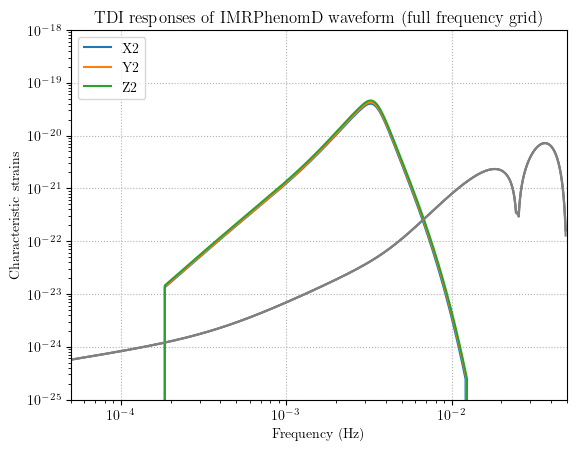

In [10]:
for ich, nch in enumerate(channel_names):
    plt.loglog(data_frequency, (np.abs(data_channels_FD_XYZ[ich].get()) * 2. * data_frequency), label=nch)
    plt.loglog(data_frequency, (np.sqrt(data_frequency * 4. / Tobs * np.abs(Cov_XYZ[ich][ich]))), color="grey")
plt.legend(loc="upper left")
plt.xlim(5e-5, fsample/2)
plt.ylim(1e-25, 1e-18)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strains")
plt.grid(linestyle=":")
plt.title("TDI responses of "+approx+" waveform (full frequency grid)")

Text(0.5, 1.0, 'TDI responses of IMRPhenomD waveform (interpolation from sparse grid)')

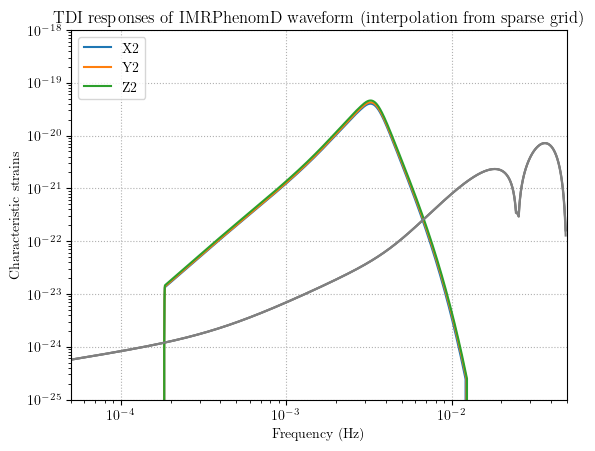

In [11]:
for ich, nch in enumerate(channel_names):
    plt.loglog(data_frequency, (np.abs(data_channels_FD_XYZ_interp[ich].get()) * 2. * data_frequency), label=nch)
    plt.loglog(data_frequency, (np.sqrt(data_frequency * 4. / Tobs * np.abs(Cov_XYZ[ich][ich]))), color="grey")
plt.legend(loc="upper left")
plt.xlim(5e-5, fsample/2)
plt.ylim(1e-25, 1e-18)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strains")
plt.grid(linestyle=":")
plt.title("TDI responses of "+approx+" waveform (interpolation from sparse grid)")

Text(0.5, 1.0, 'TDI responses of IMRPhenomD waveform')

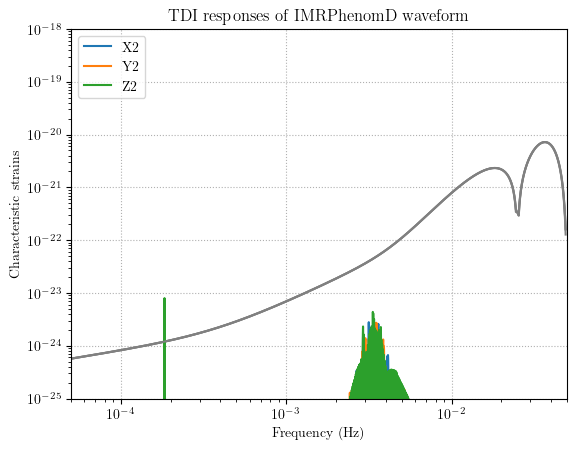

In [12]:
for ich, nch in enumerate(channel_names):
    plt.loglog(data_frequency, (np.abs(data_channels_FD_XYZ_interp[ich].get() - data_channels_FD_XYZ[ich].get()) * 2. * data_frequency), label=nch)
    plt.loglog(data_frequency, (np.sqrt(data_frequency * 4. / Tobs * np.abs(Cov_XYZ[ich][ich]))), color="grey")
plt.legend(loc="upper left")
plt.xlim(5e-5, fsample/2)
plt.ylim(1e-25, 1e-18)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strains")
plt.grid(linestyle=":")
plt.title("TDI responses of "+approx+" waveform")

## Test interp frequency grid

In [13]:
# set source parameters 
fiducial_parameters = {
    'chirp_mass': 2e6, # [MSUN]
    'mass_ratio': 0.4719138674211496, 
    'spin_1z': -0.219017,
    'spin_2z': 0.777287,
    'coalescence_time': 62., # [day]
    'coalescence_phase': 3.123620213369193,
    'luminosity_distance': 88470.94592236356, # [MPC]
    'inclination': 0.6928647958196155, # [rad]
    'longitude': 4.484587022801057, # [rad]
    'latitude': 0.9023185939708002, # [rad]
    'psi': 2.050979301490759 # [rad]
    }

response_kwargs = dict(
    modes=modes, 
    tmin=t_start / DAY,
    tmax=t_end / DAY, 
    tc_at_constellation=False, 
    TDIGeneration="2nd", 
    optimal_combination=True, 
    output_by_mode=False, 
)



# calculate tdi response 
data_channels_FD_XYZ = FDTDI.Response(
    parameters=fiducial_parameters, 
    freqs=xp.array(data_frequency),  
    **response_kwargs, 
)




Text(0.5, 1.0, 'TDI responses of IMRPhenomD waveform')

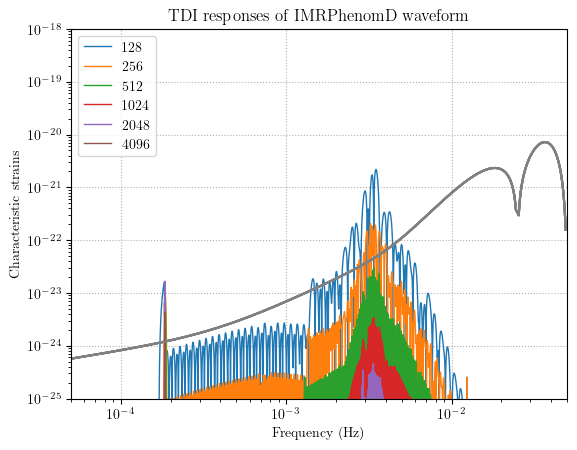

In [14]:
Nints = [128, 256, 512, 1024, 2048, 4096]

for Nint in Nints:

    response_kwargs_interp = dict(
        modes=modes, 
        tmin=t_start / DAY,
        tmax=t_end / DAY, 
        tc_at_constellation=False, 
        TDIGeneration="2nd", 
        optimal_combination=True, 
        output_by_mode=False, 
        interpolation=True, 
        interpolate_points=Nint, 
    )

    # calculate tdi response 
    data_channels_FD_XYZ_interp = FDTDI_interp.Response(
        parameters=fiducial_parameters, 
        freqs=xp.array(data_frequency),  
        **response_kwargs_interp, 
    )

    # channel_names = ["A2", "E2", "T2"]
    channel_names = ["A2",]
    for ich, nch in enumerate(channel_names):
        plt.loglog(data_frequency, (np.abs(data_channels_FD_XYZ_interp[ich].get() - data_channels_FD_XYZ[ich].get()) * 2. * data_frequency), label=str(Nint), linewidth=1)
        plt.loglog(data_frequency, (np.sqrt(data_frequency * 4. / Tobs * np.abs(Cov_XYZ[ich][ich]))), color="grey")
plt.legend(loc="upper left")
plt.xlim(5e-5, fsample/2)
plt.ylim(1e-25, 1e-18)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strains")
plt.grid(linestyle=":")
plt.title("TDI responses of "+approx+" waveform")

## Test speed 

In [15]:
# set source parameters 
fiducial_parameters = {
    'chirp_mass': 2e6, # [MSUN]
    'mass_ratio': 0.4719138674211496, 
    'spin_1z': -0.219017,
    'spin_2z': 0.777287,
    'coalescence_time': 62., # [day]
    'coalescence_phase': 3.123620213369193,
    'luminosity_distance': 88470.94592236356, # [MPC]
    'inclination': 0.6928647958196155, # [rad]
    'longitude': 4.484587022801057, # [rad]
    'latitude': 0.9023185939708002, # [rad]
    'psi': 2.050979301490759 # [rad]
    }

response_kwargs = dict(
    modes=modes, 
    tmin=t_start / DAY,
    tmax=t_end / DAY, 
    tc_at_constellation=False, 
    TDIGeneration="2nd", 
    optimal_combination=True, 
    output_by_mode=False, 
)

response_kwargs_interp = dict(
    modes=modes, 
    tmin=t_start / DAY,
    tmax=t_end / DAY, 
    tc_at_constellation=False, 
    TDIGeneration="2nd", 
    optimal_combination=True, 
    output_by_mode=False, 
    interpolation=True, 
    interpolate_points=1024, 
)


In [16]:
for _ in tqdm(range(100)):
    # calculate tdi response 
    data_channels_FD_XYZ = FDTDI.Response(
        parameters=fiducial_parameters, 
        freqs=xp.array(data_frequency),  
        **response_kwargs, 
    )

100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


In [17]:
for _ in tqdm(range(100)): 
    # calculate tdi response 
    data_channels_FD_XYZ_interp = FDTDI_interp.Response(
        parameters=fiducial_parameters, 
        freqs=xp.array(data_frequency),  
        **response_kwargs_interp, 
    )

100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


In [18]:
fiducial_parameters_arr = dict() 
for k, v in fiducial_parameters.items():
    fiducial_parameters_arr[k] =  v * np.ones(10)

In [19]:
for _ in tqdm(range(100)):
    # calculate tdi response 
    data_channels_FD_XYZ = FDTDI.Response(
        parameters=fiducial_parameters_arr, 
        freqs=xp.array(data_frequency),  
        **response_kwargs, 
    )

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


In [20]:
for _ in tqdm(range(100)): 
    # calculate tdi response 
    data_channels_FD_XYZ_interp = FDTDI_interp.Response(
        parameters=fiducial_parameters_arr, 
        freqs=xp.array(data_frequency),  
        **response_kwargs_interp, 
    )

100%|██████████| 100/100 [00:12<00:00,  8.03it/s]
